# Models creation

# 1. Introduction

This google colab file is aimed at developing models for the previously obtained dataframes. The authors of this file are:

- [Raúl Barba Rojas](mailto:Raul.Barba@alu.uclm.es)
- [Diego Guerrero Del Pozo](mailto:Diego.Guerrero@alu.uclm.es)
- [Marvin Schmidt](mailto:Marvin.Schmidt@alu.uclm.es)

# 2. TF-IDF


The first models that we need to create are related to the basic version of the NLP project, which applies vectorization only using TF-IDF. We will test two different models, which will be hyperparametrized considering crossvalidation.

## 2.1. Loading the data

The first step will be to load the data that we obtained in the previous google colab. To do so, upload the file called `tfidf.csv` to the content directory of this google colab environment.

Once that has been done, we can load the dataframe:

In [ ]:
import pandas as pd

!wget 'https://raw.githubusercontent.com/schmidt-marvin/ESI_2022_TecAA/main/task03/intermediate_files/tfidf_2.csv'

df_full = pd.read_csv('tfidf_2.csv', index_col = 'Unnamed: 0')

--2023-01-13 19:41:43--  https://raw.githubusercontent.com/schmidt-marvin/ESI_2022_TecAA/main/task03/intermediate_files/tfidf_2.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7122733 (6.8M) [text/plain]
Saving to: ‘tfidf_2.csv’

tfidf_2.csv         100%[===================>]   6.79M  --.-KB/s    in 0.03s   

2023-01-13 19:41:43 (197 MB/s) - ‘tfidf_2.csv’ saved [7122733/7122733]



Let us take a look at the data, to see whether it is balanced or not:

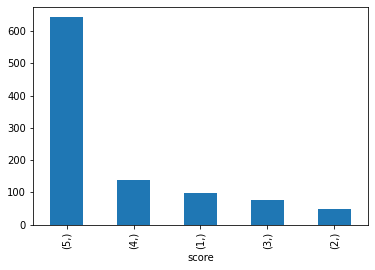

In [ ]:
df_full[['score']].value_counts().plot(kind = 'bar')

As we can see, we do have unbalanced data. To prevent unbalanced data problems, we will make use of stratified kfold (some other strategies such as oversampling or undersampling could also be used, but we will only use the stratified kfold).

Let us split the data into train and test. A 70% train and 30% test distribution is required, so let us specify those arguments in the train_test_split function of sklearn:

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(df_full.drop(columns = ['score']), df_full.score, random_state = 1, train_size = 0.7)

## 2.2. SVM

### 2.2.1. Default model

The first model that we will try is support vector machines (SVM), in this case, we will try a support vector classifier (SVC), because we have a classification problem. Let us create a default model to obtain an initial result:

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

svm_model = SVC(random_state = 0)
svm_model.fit(X_train, Y_train)
Y_pred = svm_model.predict(X_test)

Let us obtain the results for the default model:

In [ ]:
!pip install tabulate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from tabulate import tabulate

f1_val = f1_score(Y_test, Y_pred, average = 'micro')
acc_val = precision_score(Y_test, Y_pred, average = 'micro')
recall_val = recall_score(Y_test, Y_pred, average = 'micro')

print(tabulate([[acc_val, recall_val, f1_val]], headers = ['Precision', 'Recall', 'F1 Score']))

  Precision    Recall    F1 Score
-----------  --------  ----------
   0.733333  0.733333    0.733333


As we can see, the precision and the recall are exactly the same (zero difference), and the result if an f1-score of 0.73. Which is not too bad for a default model. 

Let us take a look at the confussion matrix:

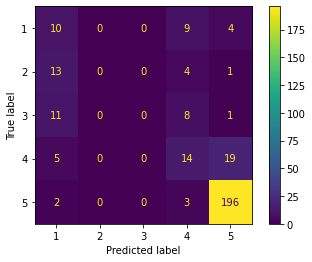

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(Y_test, Y_pred, labels= svm_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm_model.classes_)
disp.plot()

As we can see, we have the unbalanced data problem that was mentioned before, however, the good thing is that most of the times that the model predicts a score of 5, it really is 5, which is good (since that is the most typical case).

### 2.2.2. Hyperparametrization

For the SVC hyperparametrization, we will make use of GridSearchCV (using sklearn), using the stratified kfold (to prevent problems due to unbalanced data).

Firstly, we will define the following function to obtain a report of the result of the hyperparametrization:

In [ ]:
### THIS CODE WAS OBTAINED FROM THE SAMPLE CODE GIVEN IN THE SUBJECT IN THIS COLAB: https://colab.research.google.com/drive/1qk_2pqwj69Xrnj9_5i-M32tD8BceLCPE?usp=sharing

import numpy as np

def report(results, n_top=3): 
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(5)

param_grid = {'C': [0.1, 1, 10, 100], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf', 'linear', 'poly', 'sigmoid']}

model = SVC(random_state = 0)

grid_search_models = GridSearchCV(
    estimator = model,
    param_grid = param_grid,
    cv = kfold,
    n_jobs = -1,
    verbose = 2
)

grid_search_models.fit(X_train, Y_train)
report(grid_search_models.cv_results_, n_top = 5)

Fitting 5 folds for each of 80 candidates, totalling 400 fits
Model with rank: 1
Mean validation score: 0.767 (std: 0.015)
Parameters: {'C': 100, 'gamma': 1, 'kernel': 'rbf'}

Model with rank: 2
Mean validation score: 0.766 (std: 0.017)
Parameters: {'C': 10, 'gamma': 1, 'kernel': 'rbf'}

Model with rank: 3
Mean validation score: 0.737 (std: 0.024)
Parameters: {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}

Model with rank: 4
Mean validation score: 0.717 (std: 0.003)
Parameters: {'C': 1, 'gamma': 1, 'kernel': 'rbf'}

Model with rank: 5
Mean validation score: 0.679 (std: 0.016)
Parameters: {'C': 10, 'gamma': 1, 'kernel': 'sigmoid'}



As we can see, the best model uses as parameters  {'C': 100, 'gamma': 1, 'kernel': 'rbf'}, obtaining a mean validation score of 0.767 (which is better than the default model), let us create this model:

In [ ]:
svm_model = SVC(random_state = 0, C = 100, gamma = 1, kernel = 'rbf')
svm_model.fit(X_train, Y_train)
Y_pred = svm_model.predict(X_test)

Let us obtain the metric results for the hyperparametrized model:

In [ ]:
f1_val = f1_score(Y_test, Y_pred, average = 'micro')
acc_val = precision_score(Y_test, Y_pred, average = 'micro')
recall_val = recall_score(Y_test, Y_pred, average = 'micro')

print(tabulate([[acc_val, recall_val, f1_val]], headers = ['Precision', 'Recall', 'F1 Score']))

  Precision    Recall    F1 Score
-----------  --------  ----------
       0.74      0.74        0.74


As we can see, the new model is slightly better than the default one (not too much, only a bit better).

Let us take a look at its confussion matrix:

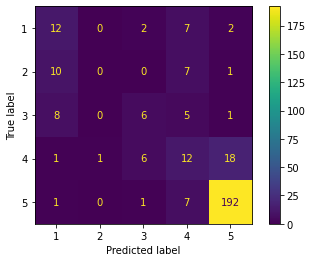

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(Y_test, Y_pred, labels= svm_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm_model.classes_)
disp.plot()

As we can see, the new model predicts slightly worse the class 5 (192 < 195), but the other labels are predicted better, which makes this model better overall (slightly) when compared to the default one.

## 2.3. XGBoost

### 2.3.1. Default model

The second model that we wanted to test is XGBoost. The main reason is that XGBoost is known because of its high performance when it comes to machine learning competitions, for instance, the machine learning competitions hosted in kaggle.

We were interested in determining whether it provides high performance in NLP or not, so we wanted to give it a try.

Let us create a default model (we will parametrize it later):

In [ ]:
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import time

from xgboost import XGBClassifier
from sklearn.metrics import f1_score

# Creates XGBoost Classifier
model = XGBClassifier(
    random_state = 0,
    tree_method = 'gpu_hist',
    n_estimators = 64
)

%time model.fit(X_train, Y_train) # train the model
Y_pred = model.predict(X_test)    # obtain the test predictions

CPU times: user 2.25 s, sys: 284 ms, total: 2.54 s
Wall time: 2.55 s


Let us obtain the results of the default xgboost model:

In [ ]:
from tabulate import tabulate
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

f1_val = f1_score(Y_test, Y_pred, average = 'micro')
acc_val = precision_score(Y_test, Y_pred, average = 'micro')
recall_val = recall_score(Y_test, Y_pred, average = 'micro')

print(tabulate([[acc_val, recall_val, f1_val]], headers = ['Precision', 'Recall', 'F1 Score']))

  Precision    Recall    F1 Score
-----------  --------  ----------
   0.666667  0.666667    0.666667


As we can see, we obtained worse results when compared to the SVM model (0.67 compared to 0.74). Let's also show the confussion matrix:

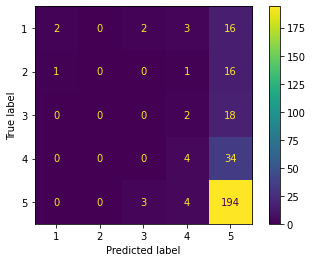

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(Y_test, Y_pred, labels= [1,2,3,4,5])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1,2,3,4,5])
disp.plot()

As we can see, it is in fact worse than the previous model, as there are many more errors in different predicted labels.

Let us try to hyperparametrize it, to see whether it can be better or not than SVM when its hyperparameters are tuned.

### 2.3.2. Hyperparametrization

In this case, in order to perform the hyperparameter tuning, we will make use of RandomSearchCV (because there are many parameters with many possible values), again using stratified Kfold (to avoid the problem of unbalanced data).

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold


kfold = StratifiedKFold(n_splits = 3) # To prevent unbalanced data problems

model = XGBClassifier(random_state = 0, tree_method = 'gpu_hist')

param_dist = {
    "learning_rate": [0.001, 0.01, 0.1],
    "n_estimators": [64, 128, 256, 512, 1024, 2048],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "subsample": [0.5, 0.7, 1.0],
    "max_depth": [3, 7, 9],
    "reg_lambda": [1, 1.5, 2],
    "gamma": [0, 0.1, 0.3],
}

random_search_models = RandomizedSearchCV(
    estimator = model, 
    param_distributions = param_dist, 
    n_iter = 50, 
    cv = kfold, 
    random_state = 0,
    n_jobs = -1,
    verbose = 3
)

random_search_models.fit(X_train, Y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
                   estimator=XGBClassifier(tree_method='gpu_hist'), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0, 0.1, 0.3],
                                        'learning_rate': [0.001, 0.01, 0.1],
                                        'max_depth': [3, 7, 9],
                                        'n_estimators': [64, 128, 256, 512,
                                                         1024, 2048],
                                        'reg_lambda': [1, 1.5, 2],
                                        'subsample': [0.5, 0.7, 1.0]},
                   random_state=0, verbose=3)

In [ ]:
report(random_search_models.cv_results_, n_top = 5)

Model with rank: 1
Mean validation score: 0.654 (std: 0.003)
Parameters: {'subsample': 1.0, 'reg_lambda': 2, 'n_estimators': 1024, 'max_depth': 9, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 0.8}

Model with rank: 2
Mean validation score: 0.654 (std: 0.009)
Parameters: {'subsample': 1.0, 'reg_lambda': 1, 'n_estimators': 1024, 'max_depth': 9, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 0.6}

Model with rank: 3
Mean validation score: 0.654 (std: 0.016)
Parameters: {'subsample': 0.5, 'reg_lambda': 2, 'n_estimators': 64, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0.3, 'colsample_bytree': 1.0}

Model with rank: 4
Mean validation score: 0.654 (std: 0.018)
Parameters: {'subsample': 0.5, 'reg_lambda': 1.5, 'n_estimators': 128, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.8}

Model with rank: 5
Mean validation score: 0.654 (std: 0.024)
Parameters: {'subsample': 0.5, 'reg_lambda': 1.5, 'n_estimators': 128, 'max_depth': 9, 'learning_rate': 0.1,

Let us build the best model after the hyperparameter tuning:

In [ ]:
parameters = {'subsample': 1.0, 'reg_lambda': 2, 'n_estimators': 1024, 'max_depth': 9, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 0.8, 'random_state' : 0}
xgboost_model = XGBClassifier(**parameters)
xgboost_model.fit(X_train, Y_train)
Y_pred = xgboost_model.predict(X_test)

Let us obtain the scores of the model:

In [ ]:
from tabulate import tabulate
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

f1_val = f1_score(Y_test, Y_pred, average = 'micro')
acc_val = precision_score(Y_test, Y_pred, average = 'micro')
recall_val = recall_score(Y_test, Y_pred, average = 'micro')

print(tabulate([[acc_val, recall_val, f1_val]], headers = ['Precision', 'Recall', 'F1 Score']))

  Precision    Recall    F1 Score
-----------  --------  ----------
   0.673333  0.673333    0.673333


Let us also obtain the confussion matrix:

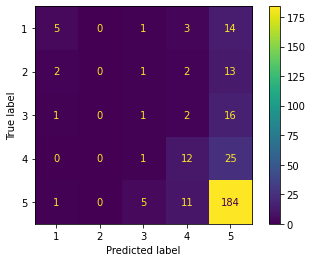

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(Y_test, Y_pred, labels= [1,2,3,4,5])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1,2,3,4,5])
disp.plot()

As we can see, the confussion matrix is still worse, as it makes more errors than the confussion matrix of the tuned SVM model, so we can conclude that the best model for the TF-IDF is SVM.

# 3. TF-IDF with n-grams

Not only we applied vectorization with TF-IDF, but we also used ngrams to see whether it was better or worse.

Let us create the same models with this new data.

## 3.1. Loading the data

The first step will be to load the data that we obtained in the previous google colab. To do so, upload the file called `tfidf_ngrams.csv` to the content directory of this google colab environment.

Once that has been done, we can load the dataframe:

In [ ]:
import pandas as pd

!wget 'https://raw.githubusercontent.com/schmidt-marvin/ESI_2022_TecAA/main/task03/intermediate_files/tfidf_ngrams_2.csv'
df_full = pd.read_csv('tfidf_ngrams_2.csv', index_col = 'Unnamed: 0')

--2023-01-10 09:17:32--  https://raw.githubusercontent.com/schmidt-marvin/ESI_2022_TecAA/main/task03/intermediate_files/tfidf_ngrams_2.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 52238996 (50M) [text/plain]
Saving to: ‘tfidf_ngrams_2.csv’

tfidf_ngrams_2.csv  100%[===================>]  49.82M   215MB/s    in 0.2s    

2023-01-10 09:17:36 (215 MB/s) - ‘tfidf_ngrams_2.csv’ saved [52238996/52238996]



Let us take a look at the data, to see whether it is balanced or not:

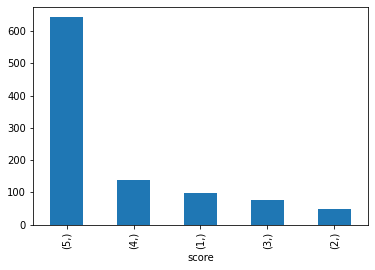

In [ ]:
df_full[['score']].value_counts().plot(kind = 'bar')

As we can see, we again have unbalanced data. To prevent unbalanced data problems, we will make use of stratified kfold (some other strategies such as oversampling or undersampling could also be used, but we will only use the stratified kfold).

Let us split the data into train and test. A 70% train and 30% test distribution is required, so let us specify those arguments in the train_test_split function of sklearn:

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(df_full.drop(columns = ['score']), df_full.score, random_state = 1, train_size = 0.7)

## 3.2. SVM

### 3.2.1. Default model

The first model that we will try is support vector machines (SVM), in this case, we will try a support vector classifier (SVC), because we have a classification problem. Let us create a default model to obtain an initial result:

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

svm_model = SVC(random_state = 0)
svm_model.fit(X_train, Y_train)
Y_pred = svm_model.predict(X_test)

Let us obtain the results for the default model:

In [ ]:
!pip install tabulate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from tabulate import tabulate

f1_val = f1_score(Y_test, Y_pred, average = 'micro')
acc_val = precision_score(Y_test, Y_pred, average = 'micro')
recall_val = recall_score(Y_test, Y_pred, average = 'micro')

print(tabulate([[acc_val, recall_val, f1_val]], headers = ['Precision', 'Recall', 'F1 Score']))

  Precision    Recall    F1 Score
-----------  --------  ----------
        0.8       0.8         0.8


As we can see, we obtained better results when compared to the previous vectorization (without ngrams). Let us see the confussion matrix as well:


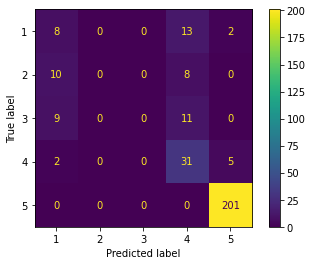

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(Y_test, Y_pred, labels= svm_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm_model.classes_)
disp.plot()

As we can see, our model does not only predict the label 5 with really high accuracy, but it also predicts the other labes decently (better than the previous models). Let us hyperparametrize it to improve the results.

### 3.2.2. Hyperparametrization

For the SVC hyperparametrization, we will make use of GridSearchCV (using sklearn), using the stratified kfold (to prevent problems due to unbalanced data).

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(5)

param_grid = {'C': [0.1, 1, 10, 100], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf', 'linear', 'poly', 'sigmoid']}

model = SVC(random_state = 0)

grid_search_models = GridSearchCV(
    estimator = model,
    param_grid = param_grid,
    cv = kfold,
    n_jobs = -1,
    verbose = 2
)

grid_search_models.fit(X_train, Y_train)
report(grid_search_models.cv_results_, n_top = 5)

Fitting 5 folds for each of 80 candidates, totalling 400 fits
Model with rank: 1
Mean validation score: 0.817 (std: 0.013)
Parameters: {'C': 10, 'gamma': 1, 'kernel': 'rbf'}

Model with rank: 1
Mean validation score: 0.817 (std: 0.013)
Parameters: {'C': 100, 'gamma': 1, 'kernel': 'rbf'}

Model with rank: 3
Mean validation score: 0.783 (std: 0.012)
Parameters: {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}

Model with rank: 4
Mean validation score: 0.776 (std: 0.021)
Parameters: {'C': 1, 'gamma': 1, 'kernel': 'rbf'}

Model with rank: 5
Mean validation score: 0.771 (std: 0.014)
Parameters: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}



Let us build the best model:

In [ ]:
parameters = {'C': 10, 'gamma': 1, 'kernel': 'rbf', 'random_state' : 0}

svm_model = SVC(**parameters)
svm_model.fit(X_train, Y_train)
Y_pred = svm_model.predict(X_test)

Let's obtain the results with this new model:

In [ ]:
from tabulate import tabulate

f1_val = f1_score(Y_test, Y_pred, average = 'micro')
acc_val = precision_score(Y_test, Y_pred, average = 'micro')
recall_val = recall_score(Y_test, Y_pred, average = 'micro')

print(tabulate([[acc_val, recall_val, f1_val]], headers = ['Precision', 'Recall', 'F1 Score']))

  Precision    Recall    F1 Score
-----------  --------  ----------
   0.826667  0.826667    0.826667


As we can see, we improved the results quite a bit by only performing parameter tuning.

Let us also obtain its confussion matrix:

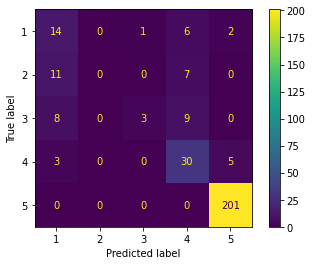

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(Y_test, Y_pred, labels= svm_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm_model.classes_)
disp.plot()

As we can see, now our model predicts even better those other labels different than 5 (less errors in the unbalanced classes), so this model is actually really good (currently the best).

## 3.3. XGBoost

Let us obtain the results using XGBoost to establish the same comparison.

### 3.3.1. Default model

Let us create a default model (we will parametrize it later):

In [ ]:
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import time

from xgboost import XGBClassifier
from sklearn.metrics import f1_score

# Creates XGBoost Classifier
model = XGBClassifier(
    random_state = 0,
    tree_method = 'gpu_hist',
    n_estimators = 64
)

%time model.fit(X_train, Y_train) # train the model
Y_pred = model.predict(X_test)    # obtain the test predictions

CPU times: user 7.96 s, sys: 2.84 s, total: 10.8 s
Wall time: 14.7 s


Let us obtain the results of the default xgboost model:

In [ ]:
from tabulate import tabulate
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

f1_val = f1_score(Y_test, Y_pred, average = 'micro')
acc_val = precision_score(Y_test, Y_pred, average = 'micro')
recall_val = recall_score(Y_test, Y_pred, average = 'micro')

print(tabulate([[acc_val, recall_val, f1_val]], headers = ['Precision', 'Recall', 'F1 Score']))

  Precision    Recall    F1 Score
-----------  --------  ----------
       0.66      0.66        0.66


As we can see, we obtained even worse results compared to TF-IDF itself, let us also see the confussion matrix:

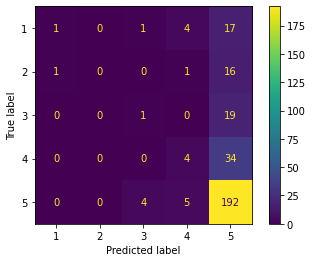

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(Y_test, Y_pred, labels= [1,2,3,4,5])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1,2,3,4,5])
disp.plot()

As we can see in the confussion matrix, this model works better for predicting the 5th label, but it makes more mistakes in other labels (it tends to predict everything as 5)

### 3.3.2. Hyperparametrization

In this case, in order to perform the hyperparameter tuning, we will make use of RandomSearchCV (because there are many parameters with many possible values), again using stratified Kfold (to avoid the problem of unbalanced data).

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold


kfold = StratifiedKFold(n_splits = 3) # To prevent unbalanced data problems

model = XGBClassifier(random_state = 0, tree_method = 'gpu_hist')

param_dist = {
    "learning_rate": [0.001, 0.01, 0.1],
    "n_estimators": [64, 128, 256, 512, 1024, 2048],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "subsample": [0.5, 0.7, 1.0],
    "max_depth": [3, 7, 9],
    "reg_lambda": [1, 1.5, 2],
    "gamma": [0, 0.1, 0.3],
}

random_search_models = RandomizedSearchCV(
    estimator = model, 
    param_distributions = param_dist, 
    n_iter = 50, 
    cv = kfold, 
    random_state = 0,
    n_jobs = -1,
    verbose = 3
)

random_search_models.fit(X_train, Y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
                   estimator=XGBClassifier(tree_method='gpu_hist'), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0, 0.1, 0.3],
                                        'learning_rate': [0.001, 0.01, 0.1],
                                        'max_depth': [3, 7, 9],
                                        'n_estimators': [64, 128, 256, 512,
                                                         1024, 2048],
                                        'reg_lambda': [1, 1.5, 2],
                                        'subsample': [0.5, 0.7, 1.0]},
                   random_state=0, verbose=3)

In [ ]:
report(random_search_models.cv_results_, n_top = 5)

Model with rank: 1
Mean validation score: 0.660 (std: 0.012)
Parameters: {'subsample': 0.5, 'reg_lambda': 2, 'n_estimators': 64, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0.3, 'colsample_bytree': 1.0}

Model with rank: 2
Mean validation score: 0.660 (std: 0.011)
Parameters: {'subsample': 0.5, 'reg_lambda': 1.5, 'n_estimators': 128, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.8}

Model with rank: 3
Mean validation score: 0.659 (std: 0.020)
Parameters: {'subsample': 0.5, 'reg_lambda': 1.5, 'n_estimators': 128, 'max_depth': 9, 'learning_rate': 0.1, 'gamma': 0.3, 'colsample_bytree': 1.0}

Model with rank: 4
Mean validation score: 0.656 (std: 0.022)
Parameters: {'subsample': 0.7, 'reg_lambda': 1.5, 'n_estimators': 256, 'max_depth': 9, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 1.0}

Model with rank: 5
Mean validation score: 0.651 (std: 0.008)
Parameters: {'subsample': 1.0, 'reg_lambda': 1.5, 'n_estimators': 128, 'max_depth': 3, 'learning_rate': 0.

Let us build the best model after the hyperparameter tuning:

In [ ]:
parameters = {'subsample': 0.5, 'reg_lambda': 2, 'n_estimators': 64, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0.3, 'colsample_bytree': 1.0, 'random_state' : 0}

model = XGBClassifier(**parameters)
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)

Let's obtain the results of the tuned xgboost model:

In [ ]:
from tabulate import tabulate
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

f1_val = f1_score(Y_test, Y_pred, average = 'micro')
acc_val = precision_score(Y_test, Y_pred, average = 'micro')
recall_val = recall_score(Y_test, Y_pred, average = 'micro')

print(tabulate([[acc_val, recall_val, f1_val]], headers = ['Precision', 'Recall', 'F1 Score']))

  Precision    Recall    F1 Score
-----------  --------  ----------
       0.67      0.67        0.67


As we can see, it is slightly better than the default model, however, it is much worse when compared to the SVM model. Let us confirm it by showing the confussion matrix:

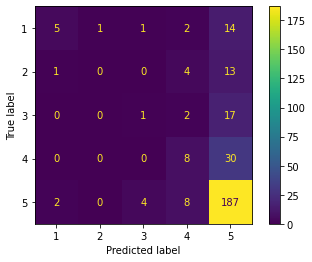

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(Y_test, Y_pred, labels= [1,2,3,4,5])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1,2,3,4,5])
disp.plot()

As it was mentioned above, XGBoost on the TF-IDF with n-grams does not improve (it is actually worse) the TF-IDF version using XGBoost.

Furthermore, it is still much worse when compared to SVM. The SVM model of TF-IDF with n-grams is currently the best model.

# 4. TF-IDF n-grams with pos tagging

The next models that we have to create are related to TF-IDF with n-grams (2 only) and pos tagging. We will follow the same procedure as in the previous ones.

## 4.1. Loading the data

In [ ]:
import pandas as pd

!wget 'https://raw.githubusercontent.com/schmidt-marvin/ESI_2022_TecAA/main/task03/intermediate_files/tfidf_ngrams_postag.csv'

df_full = pd.read_csv('tfidf_ngrams_postag.csv', index_col = 'Unnamed: 0')

--2023-01-11 09:25:08--  https://raw.githubusercontent.com/schmidt-marvin/ESI_2022_TecAA/main/task03/intermediate_files/tfidf_ngrams_postag.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 52243848 (50M) [text/plain]
Saving to: ‘tfidf_ngrams_postag.csv’

tfidf_ngrams_postag 100%[===================>]  49.82M   155MB/s    in 0.3s    

2023-01-11 09:25:09 (155 MB/s) - ‘tfidf_ngrams_postag.csv’ saved [52243848/52243848]



Let us take a look at the data, to see whether it is balanced or not:

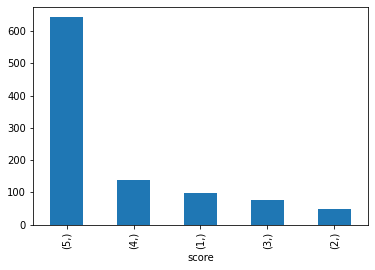

In [ ]:
df_full[['score']].value_counts().plot(kind = 'bar')

As we can see, we again have unbalanced data. To prevent unbalanced data problems, we will make use of stratified kfold (some other strategies such as oversampling or undersampling could also be used, but we will only use the stratified kfold).

Let us split the data into train and test. A 70% train and 30% test distribution is required, so let us specify those arguments in the train_test_split function of sklearn:

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(df_full.drop(columns = ['score']), df_full.score, random_state = 1, train_size = 0.7)

## 4.2. SVM

### 4.2.1. Default model

The first model that we will try is support vector machines (SVM), in this case, we will try a support vector classifier (SVC), because we have a classification problem. Let us create a default model to obtain an initial result:

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

svm_model = SVC(random_state = 0)
svm_model.fit(X_train, Y_train)
Y_pred = svm_model.predict(X_test)

Let us obtain the results for the default model:

In [ ]:
!pip install tabulate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from tabulate import tabulate

f1_val = f1_score(Y_test, Y_pred, average = 'micro')
acc_val = precision_score(Y_test, Y_pred, average = 'micro')
recall_val = recall_score(Y_test, Y_pred, average = 'micro')

print(tabulate([[acc_val, recall_val, f1_val]], headers = ['Precision', 'Recall', 'F1 Score']))

  Precision    Recall    F1 Score
-----------  --------  ----------
        0.8       0.8         0.8


Let us also take a look at the confussion matrix:

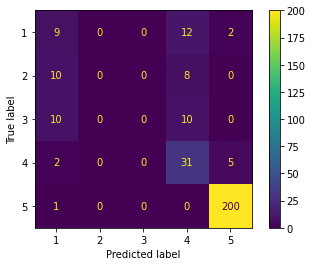

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(Y_test, Y_pred, labels= svm_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm_model.classes_)
disp.plot()

As we can see, the default SVM model for the configuration with TF-IDF vectorization, ngrams and pos tagging gives actually good results, but at this point, there is no difference (from the metrics point of view) with respect to the default SVM model of the previous configuration (without pos tagging).

With respect to the confussion matrix, we can see that it almost makes no mistakes when predicting 5, however, it does make more mistakes in the other labels.

### 4.2.2. Hyperparametrization

Let us tune the parameters to see if it can improve the current best model:

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(5)

param_grid = {'C': [0.1, 1, 10, 100], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf', 'linear', 'poly', 'sigmoid']}

model = SVC(random_state = 0)

grid_search_models = GridSearchCV(
    estimator = model,
    param_grid = param_grid,
    cv = kfold,
    n_jobs = -1,
    verbose = 2
)

grid_search_models.fit(X_train, Y_train)
report(grid_search_models.cv_results_, n_top = 5)

Fitting 5 folds for each of 80 candidates, totalling 400 fits
Model with rank: 1
Mean validation score: 0.816 (std: 0.008)
Parameters: {'C': 10, 'gamma': 1, 'kernel': 'rbf'}

Model with rank: 1
Mean validation score: 0.816 (std: 0.008)
Parameters: {'C': 100, 'gamma': 1, 'kernel': 'rbf'}

Model with rank: 3
Mean validation score: 0.784 (std: 0.014)
Parameters: {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}

Model with rank: 4
Mean validation score: 0.773 (std: 0.022)
Parameters: {'C': 1, 'gamma': 1, 'kernel': 'rbf'}

Model with rank: 4
Mean validation score: 0.773 (std: 0.011)
Parameters: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}



Let us create the tuned model:

In [ ]:
parameters = {'C': 100, 'gamma': 1, 'kernel': 'rbf'}

svm_model = SVC(**parameters)
svm_model.fit(X_train, Y_train)
Y_pred = svm_model.predict(X_test)

Let us obtain the coefficients for this model:

In [ ]:
f1_val = f1_score(Y_test, Y_pred, average = 'micro')
acc_val = precision_score(Y_test, Y_pred, average = 'micro')
recall_val = recall_score(Y_test, Y_pred, average = 'micro')

print(tabulate([[acc_val, recall_val, f1_val]], headers = ['Precision', 'Recall', 'F1 Score']))

  Precision    Recall    F1 Score
-----------  --------  ----------
       0.83      0.83        0.83


And let us also calculate its confussion matrix:

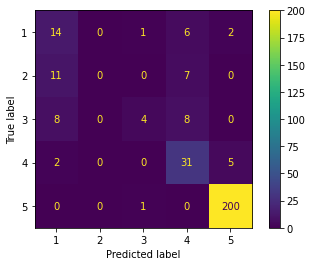

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(Y_test, Y_pred, labels= svm_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm_model.classes_)
disp.plot()

As we can see, this model is actually the current best model for the task, as it has better metrics when compared to the others. The only mistake that the model makes is that it never predicts label 2, probably because of the unbalanced data problem.

## 4.3. XGBoost

### 4.3.1. Default model

Let us create a default model (we will parametrize it later):

In [ ]:
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import time

from xgboost import XGBClassifier
from sklearn.metrics import f1_score

# Creates XGBoost Classifier
model = XGBClassifier(
    random_state = 0,
    tree_method = 'gpu_hist',
    n_estimators = 64
)

%time model.fit(X_train, Y_train) # train the model
Y_pred = model.predict(X_test)    # obtain the test predictions

CPU times: user 7.65 s, sys: 2.11 s, total: 9.77 s
Wall time: 10 s


Let us obtain the results of the default model:

In [ ]:
from tabulate import tabulate
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

f1_val = f1_score(Y_test, Y_pred, average = 'micro')
acc_val = precision_score(Y_test, Y_pred, average = 'micro')
recall_val = recall_score(Y_test, Y_pred, average = 'micro')

print(tabulate([[acc_val, recall_val, f1_val]], headers = ['Precision', 'Recall', 'F1 Score']))

  Precision    Recall    F1 Score
-----------  --------  ----------
       0.67      0.67        0.67


Let us also compute the confussion matrix:

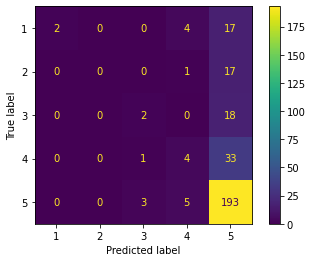

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(Y_test, Y_pred, labels= [1,2,3,4,5])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1,2,3,4,5])
disp.plot()

As we can see from the results, the model is slightly better than the previous XGBoost versions, however, it is still much worse than the SVM models. The main problem of this model is that it pretty much always tries the label 5 prediction, missing a high number of times (probably because of the unbalance, this can be solved when tuning the algorithm if we use stratified kfold). 

### 4.3.2. Hyperparametrization

Let us tune the algorithm:

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold


kfold = StratifiedKFold(n_splits = 3) # To prevent unbalanced data problems

model = XGBClassifier(random_state = 0, tree_method = 'gpu_hist')

param_dist = {
    "learning_rate": [0.001, 0.01, 0.1],
    "n_estimators": [64, 128, 256, 512, 1024, 2048],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "subsample": [0.5, 0.7, 1.0],
    "max_depth": [3, 7, 9],
    "reg_lambda": [1, 1.5, 2],
    "gamma": [0, 0.1, 0.3],
}

random_search_models = RandomizedSearchCV(
    estimator = model, 
    param_distributions = param_dist, 
    n_iter = 50, 
    cv = kfold, 
    random_state = 0,
    n_jobs = -1,
    verbose = 3
)

random_search_models.fit(X_train, Y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
                   estimator=XGBClassifier(tree_method='gpu_hist'), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0, 0.1, 0.3],
                                        'learning_rate': [0.001, 0.01, 0.1],
                                        'max_depth': [3, 7, 9],
                                        'n_estimators': [64, 128, 256, 512,
                                                         1024, 2048],
                                        'reg_lambda': [1, 1.5, 2],
                                        'subsample': [0.5, 0.7, 1.0]},
                   random_state=0, verbose=3)

In [ ]:
report(random_search_models.cv_results_, n_top = 5)

Model with rank: 1
Mean validation score: 0.656 (std: 0.008)
Parameters: {'subsample': 0.5, 'reg_lambda': 1.5, 'n_estimators': 64, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.6}

Model with rank: 2
Mean validation score: 0.651 (std: 0.006)
Parameters: {'subsample': 0.5, 'reg_lambda': 2, 'n_estimators': 64, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0.3, 'colsample_bytree': 1.0}

Model with rank: 3
Mean validation score: 0.650 (std: 0.004)
Parameters: {'subsample': 0.5, 'reg_lambda': 1, 'n_estimators': 1024, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.1, 'colsample_bytree': 0.6}

Model with rank: 3
Mean validation score: 0.650 (std: 0.004)
Parameters: {'subsample': 0.5, 'reg_lambda': 1, 'n_estimators': 1024, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.3, 'colsample_bytree': 0.6}

Model with rank: 5
Mean validation score: 0.650 (std: 0.009)
Parameters: {'subsample': 0.5, 'reg_lambda': 1.5, 'n_estimators': 128, 'max_depth': 3, 'learning_rate':

Let us build the tuned model:

In [ ]:
parameters = {'subsample': 0.5, 'reg_lambda': 1.5, 'n_estimators': 64, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.6, 'random_state' : 0}
model = XGBClassifier(**parameters)
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)

Let us obtain the results of the tuned model:

In [ ]:
from tabulate import tabulate
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

f1_val = f1_score(Y_test, Y_pred, average = 'micro')
acc_val = precision_score(Y_test, Y_pred, average = 'micro')
recall_val = recall_score(Y_test, Y_pred, average = 'micro')

print(tabulate([[acc_val, recall_val, f1_val]], headers = ['Precision', 'Recall', 'F1 Score']))

  Precision    Recall    F1 Score
-----------  --------  ----------
   0.686667  0.686667    0.686667


Let us also compute its confussion matrix:

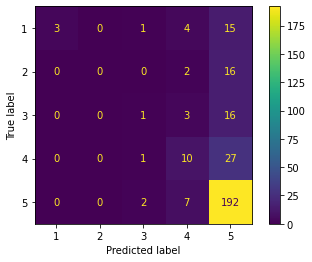

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(Y_test, Y_pred, labels= [1,2,3,4,5])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1,2,3,4,5])
disp.plot()

As we can see, this is currently the best XGBoost model but it is still worse when compared to the SVM models. 

The main problems are related to predicting many times the label 5 (and failing), and not predicting some other labels (e.g. label 2 is never predicted by the model).

# 5. TF-IDF n-grams with pos tagging and additional features

The last models that we have to create are related to TF-IDF with n-grams (2 only), pos tagging and additional features. We will follow the same procedure as in the previous ones.

## 5.1. Loading the data

In [ ]:
import pandas as pd

!wget 'https://raw.githubusercontent.com/schmidt-marvin/ESI_2022_TecAA/main/task03/intermediate_files/tfidf_ngrams_postag_other.csv'

df_full = pd.read_csv('tfidf_ngrams_postag_other.csv', index_col = 'Unnamed: 0')

--2023-01-14 15:18:04--  https://raw.githubusercontent.com/schmidt-marvin/ESI_2022_TecAA/main/task03/intermediate_files/tfidf_ngrams_postag_other.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 52282962 (50M) [text/plain]
Saving to: ‘tfidf_ngrams_postag_other.csv’

tfidf_ngrams_postag 100%[===================>]  49.86M   239MB/s    in 0.2s    

2023-01-14 15:18:07 (239 MB/s) - ‘tfidf_ngrams_postag_other.csv’ saved [52282962/52282962]



Let us take a look at the data, to see whether it is balanced or not:

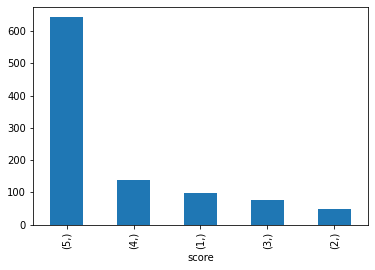

In [ ]:
df_full[['score']].value_counts().plot(kind = 'bar')

As we can see, we again have unbalanced data. To prevent unbalanced data problems, we will make use of stratified kfold (some other strategies such as oversampling or undersampling could also be used, but we will only use the stratified kfold).

Let us split the data into train and test. A 70% train and 30% test distribution is required, so let us specify those arguments in the train_test_split function of sklearn:

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(df_full.drop(columns = ['score']), df_full.score, random_state = 1, train_size = 0.7)

## 5.2. SVM

### 5.2.1. Default model

The first model that we will try is support vector machines (SVM), in this case, we will try a support vector classifier (SVC), because we have a classification problem. Let us create a default model to obtain an initial result:

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

svm_model = SVC(random_state = 0)
svm_model.fit(X_train, Y_train)
Y_pred = svm_model.predict(X_test)

Let us obtain the results of the default model:

In [ ]:
!pip install tabulate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from tabulate import tabulate

f1_val = f1_score(Y_test, Y_pred, average = 'micro')
acc_val = precision_score(Y_test, Y_pred, average = 'micro')
recall_val = recall_score(Y_test, Y_pred, average = 'micro')

print(tabulate([[acc_val, recall_val, f1_val]], headers = ['Precision', 'Recall', 'F1 Score']))

  Precision    Recall    F1 Score
-----------  --------  ----------
   0.806667  0.806667    0.806667


Let us also take a look at the confussion matrix:

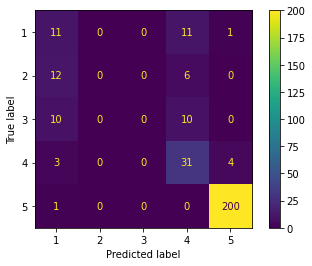

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(Y_test, Y_pred, labels= svm_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm_model.classes_)
disp.plot()

As we can see, the default model obtained with SVM is actually not a bad model, in fact, it is the best default model obtained at the moment (it is not the best overall model).

Its main problem is that it will never predict labels 2 or 3 (probably due to the unbalance in the data), let us see if after tuning the algorithm it improves it or not.

### 5.2.2. Hyperpametrization

Let us tune the model in the same way as before:

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(5)

param_grid = {'C': [0.1, 1, 10, 100], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf', 'linear', 'poly', 'sigmoid']}

model = SVC(random_state = 0)

grid_search_models = GridSearchCV(
    estimator = model,
    param_grid = param_grid,
    cv = kfold,
    n_jobs = -1,
    verbose = 2
)

grid_search_models.fit(X_train, Y_train)
report(grid_search_models.cv_results_, n_top = 5)

Fitting 5 folds for each of 80 candidates, totalling 400 fits
Model with rank: 1
Mean validation score: 0.809 (std: 0.007)
Parameters: {'C': 10, 'gamma': 1, 'kernel': 'rbf'}

Model with rank: 1
Mean validation score: 0.809 (std: 0.007)
Parameters: {'C': 100, 'gamma': 1, 'kernel': 'rbf'}

Model with rank: 3
Mean validation score: 0.779 (std: 0.016)
Parameters: {'C': 1, 'gamma': 1, 'kernel': 'rbf'}

Model with rank: 4
Mean validation score: 0.774 (std: 0.018)
Parameters: {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}

Model with rank: 5
Mean validation score: 0.770 (std: 0.020)
Parameters: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}



Let us build the best model:

In [ ]:
parameters = {'C': 10, 'gamma': 1, 'kernel': 'rbf'}

svm_model = SVC(**parameters)
svm_model.fit(X_train, Y_train)
Y_pred = svm_model.predict(X_test)

Let us obtain its results:

In [ ]:
from tabulate import tabulate

f1_val = f1_score(Y_test, Y_pred, average = 'micro')
acc_val = precision_score(Y_test, Y_pred, average = 'micro')
recall_val = recall_score(Y_test, Y_pred, average = 'micro')

print(tabulate([[acc_val, recall_val, f1_val]], headers = ['Precision', 'Recall', 'F1 Score']))

  Precision    Recall    F1 Score
-----------  --------  ----------
   0.826667  0.826667    0.826667


And also its confussion matrix:

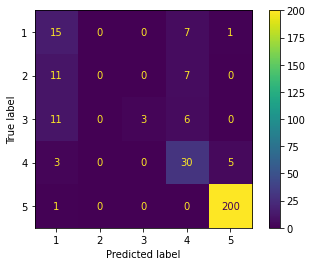

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(Y_test, Y_pred, labels= svm_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm_model.classes_)
disp.plot()

As we can see, we obtained a really good model, whose scores are actually great. Its main problem is still the label 2. Due to the unbalance in the data, it never predicts the label 2, however, it gets good results anyway, so we do not consider it to be critical (it is hard that the user labels 2, thats why the model tends to predict otehr labels such as 1 or 3 for those cases).

Anyway, this is the best model obtained so far, let us see if XGBoost can compete with it (it could not in the previous cases, let us see if it can in this case).

## 5.3. XGBoost

### 5.3.1. Default model

Let us create a default model (we will parametrize it later):

In [ ]:
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import time

from xgboost import XGBClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# Creates XGBoost Classifier
model = XGBClassifier(
    random_state = 0,
    tree_method = 'gpu_hist',
    n_estimators = 64
)

%time model.fit(X_train, Y_train) # train the model
Y_pred = model.predict(X_test)    # obtain the test predictions

CPU times: user 7.46 s, sys: 1.97 s, total: 9.42 s
Wall time: 10.5 s


Let us obtain the results for the default model:

In [ ]:
from tabulate import tabulate

f1_val = f1_score(Y_test, Y_pred, average = 'micro')
acc_val = precision_score(Y_test, Y_pred, average = 'micro')
recall_val = recall_score(Y_test, Y_pred, average = 'micro')

print(tabulate([[acc_val, recall_val, f1_val]], headers = ['Precision', 'Recall', 'F1 Score']))

  Precision    Recall    F1 Score
-----------  --------  ----------
   0.663333  0.663333    0.663333


And also its confussion matrix:

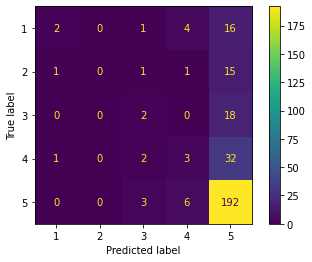

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(Y_test, Y_pred, labels= model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()

Again, we obtained a model that is much worse when compared to the current best model that uses SVM. It has the same problem that it never predicts 2, but it also has other problems such as relatively low accuracy when predicting 5.

Let us see if we can tune this model to make it work better.

### 5.3.2. Hyperparametrization

Let's also tune the xgboost algorithm to see if it can compete with the tuned SVM model or not:

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold


kfold = StratifiedKFold(n_splits = 3) # To prevent unbalanced data problems

model = XGBClassifier(random_state = 0, tree_method = 'gpu_hist')

param_dist = {
    "learning_rate": [0.001, 0.01, 0.1],
    "n_estimators": [64, 128, 256, 512, 1024, 2048],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "subsample": [0.5, 0.7, 1.0],
    "max_depth": [3, 7, 9],
    "reg_lambda": [1, 1.5, 2],
    "gamma": [0, 0.1, 0.3],
}

random_search_models = RandomizedSearchCV(
    estimator = model, 
    param_distributions = param_dist, 
    n_iter = 50, 
    cv = kfold, 
    random_state = 0,
    n_jobs = -1,
    verbose = 3
)

random_search_models.fit(X_train, Y_train)
report(random_search_models.cv_results_, n_top = 5)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Model with rank: 1
Mean validation score: 0.654 (std: 0.003)
Parameters: {'subsample': 1.0, 'reg_lambda': 2, 'n_estimators': 1024, 'max_depth': 9, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 0.8}

Model with rank: 2
Mean validation score: 0.654 (std: 0.009)
Parameters: {'subsample': 1.0, 'reg_lambda': 1, 'n_estimators': 1024, 'max_depth': 9, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 0.6}

Model with rank: 3
Mean validation score: 0.654 (std: 0.016)
Parameters: {'subsample': 0.5, 'reg_lambda': 2, 'n_estimators': 64, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0.3, 'colsample_bytree': 1.0}

Model with rank: 4
Mean validation score: 0.654 (std: 0.018)
Parameters: {'subsample': 0.5, 'reg_lambda': 1.5, 'n_estimators': 128, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.8}

Model with rank: 5
Mean validation score: 0.654 (std: 0.024)
Parameters: {'subsample': 0.5, 'reg_lambda': 1.5, 'n_estimators': 128, 'max_depth': 9, 'learning_rate': 0.1,

Let's build the tuned model:

In [ ]:
parameters = {'subsample': 1.0, 'reg_lambda': 2, 'n_estimators': 1024, 'max_depth': 9, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 0.8, 'random_state' : 0}
model = XGBClassifier(**parameters)

model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)

Let us obtain its results:

In [ ]:
from tabulate import tabulate

f1_val = f1_score(Y_test, Y_pred, average = 'micro')
acc_val = precision_score(Y_test, Y_pred, average = 'micro')
recall_val = recall_score(Y_test, Y_pred, average = 'micro')

print(tabulate([[acc_val, recall_val, f1_val]], headers = ['Precision', 'Recall', 'F1 Score']))

  Precision    Recall    F1 Score
-----------  --------  ----------
   0.673333  0.673333    0.673333


Also its confussion matrix:

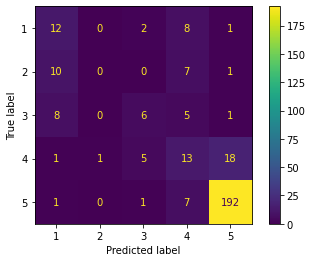

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(Y_test, Y_pred, labels= svm_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm_model.classes_)
disp.plot()

As we can see, the tuned model is actually bad. It  is worse than previous tuned XGBoost model, and much worse when compared to the tuned SVM models.

It does try to predict 2 and 3, which is something that the default model would never do, but it makes multiple errors in its predictions (compare the confussion matrices) 

# 6. Conclusions

To conclude, we wanted to point out several lessons learned from the study:

1. SVM looks generally better for this specific task when compared to XGBoost, as all the SVM models are better than the XGBoost models (even when they are tuned).

2. Models will rarely predict label 2, most likely due to the unbalance in the data (it is really unlikely that someone will rate a product with 2 stars, probably 1 or 5 are the most common).

3. A two-phase classification could be used for further improving the results (probably it would not improve too much, but it could improve the results slightly). The procedure would be as follows: a model would decide whether it is 5 rating or not (binary classification), for those predicted as no-5 rating, another model would predict which rating they should have. This kind of procedure (that we developed in the second project of this course) generally improves slightly the results when we have unbalanced data, as it is the case.


Finally, we put here a table to show the obtained scores by the different models:

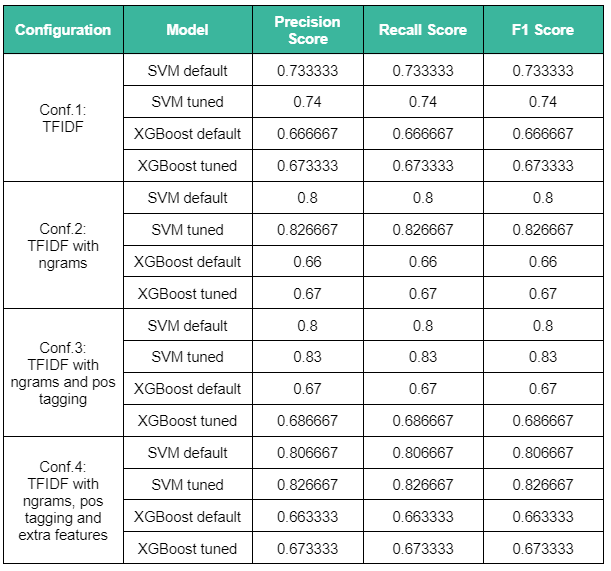

As we can see from the table, we developed 4 different configurations, applying the same algorithms with and without tuning.

The results show how there are 2 models that achieve the highest scores:

1. SVM model on configuration 2 (tuned).
2. SVM model on configuration 4 (tuned).

If we take a look at the confussion matrices, they are pretty similar (they will never predict a rating of 2, and they will rarely predict a rating of 3).

Thus, we conclude that the best model is SVM on configuration 2 (tuned), because it is simpler and it gives the same results (there is not a real difference between them).